In [7]:
import logging
import os
import numpy as np
import pandas as pd
from progress.bar import Bar
import logging
import time
from scipy.spatial import distance
import shutil
import argparse

logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)

period = 20

In [3]:
%run load_data.ipynb

2020-05-19 06:43:26,098 Reading stock data files under directory C:\export\sha_set
2020-05-19 06:43:26,106 Start loading sha stock data


Loading sha stock data |###########                     | 593/1622oading sha stock data |                                | 28/1622Loading sha stock data |                                | 37/1622Loading sha stock data |                                | 42/1622Loading sha stock data |#                               | 56/1622Loading sha stock data |#                               | 61/1622Loading sha stock data |#                               | 66/1622Loading sha stock data |#                               | 67/1622Loading sha stock data |#                               | 68/1622Loading sha stock data |#                               | 69/1622Loading sha stock data |#                               | 70/1622Loading sha stock data |#                               | 71/1622Loading sha stock data |#                               | 79/1622Loading sha stock data |##                              | 103/1622Loading sha stock data |##                              | 107/1622Loading sha stock data 

Loading sha stock data |####################            | 1042/1622oading sha stock data |###########                     | 597/1622Loading sha stock data |###########                     | 600/1622Loading sha stock data |###########                     | 602/1622Loading sha stock data |###########                     | 606/1622Loading sha stock data |############                    | 610/1622Loading sha stock data |############                    | 612/1622Loading sha stock data |############                    | 613/1622Loading sha stock data |############                    | 614/1622Loading sha stock data |############                    | 615/1622Loading sha stock data |############                    | 616/1622Loading sha stock data |############                    | 618/1622Loading sha stock data |############                    | 619/1622Loading sha stock data |############                    | 621/1622Loading sha stock data |############                    | 622/1622Loading sh

Loading sha stock data |################################| 1622/1622Loading sha stock data |####################            | 1047/1622Loading sha stock data |####################            | 1048/1622Loading sha stock data |####################            | 1050/1622Loading sha stock data |####################            | 1051/1622Loading sha stock data |####################            | 1053/1622Loading sha stock data |####################            | 1054/1622Loading sha stock data |####################            | 1055/1622Loading sha stock data |#####################           | 1075/1622Loading sha stock data |#####################           | 1076/1622Loading sha stock data |#####################           | 1093/1622Loading sha stock data |#####################           | 1100/1622Loading sha stock data |#####################           | 1102/1622Loading sha stock data |#####################           | 1109/1622Loading sha stock data |######################          | 1140

In [53]:
def chebyshev_fit(series, deg):
        x = np.arange(0, series.shape[0], 1)
        y = series

        p = np.polynomial.Chebyshev.fit(x, y, deg)
        y_fit = p(x)

        return y_fit

# real test
#idx_suffix = 2 * period
# loop test
idx_suffix = 4 * period

def find_similarity(sample_a, db, method, step=1, n_similar=10, reg=True, deg=9, lcr_threshold=0.005):
        sample_a_name = sample_a['Name'][0]
        logging.info('[Similarity] {} in period [{} {}]'.format(sample_a_name, sample_a.index[0], sample_a.index[-1]))
        period = sample_a.shape[0]

        change_a = sample_a['Change']
        fit_a = change_a
        if reg is True:
                fit_a = chebyshev_fit(change_a, deg)

#        ref_close = 100
#        close_a = sample_a['Close']
#        close_a = close_a / close_a[0] * ref_close
#        linear_fit_a = chebyshev_fit(close_a, 1)
#        lcr_a = (linear_fit_a[-1] - linear_fit_a[0]) / linear_fit_a[0]

        result = {}

        sample_b_cnt = 0

        for stock_type in db:
                start_time = time.time()
                #logging.info('[Similarity] in {} for {}'.format(stock_type, sample_a_name))

                stock_ids_cnt = len(db[stock_type])
                progress_bar = Bar('[Similarity] Processing {} in {}'.format(sample_a_name, stock_type), max=stock_ids_cnt)
                progress_bar.check_tty = False

                for stock_id in db[stock_type]:

                        df = db[stock_type][stock_id]

                        idx = df.shape[0] - idx_suffix
                        for i in np.arange(0, idx, step):
                                sample_b = df.iloc[i : i + period]

#                                # calculate linear change rate, ignore exceeds +-0.5%
#                                close_b = sample_b['Close']
#                                close_b = close_b / close_b[0] * ref_close
#                                linear_fit_b = chebyshev_fit(close_b, 1)
#                                lcr_b = (linear_fit_b[-1] - linear_fit_b[0]) / linear_fit_b[0]

#                                if lcr_b < lcr_a - lcr_threshold or lcr_b > lcr_a + lcr_threshold:
#                                        continue

                                # get another sample_b, which start from row i and contains period rows
                                change_b = sample_b['Change']
                                fit_b = change_b
                                if reg is True:
                                        fit_b = chebyshev_fit(change_b, deg)

                                # chebyshev distance
                                dist = None
                                if method == 'chebyshev':
                                    dist = distance.chebyshev(fit_a, fit_b)
                                elif method == 'cosine':
                                    dist = distance.cosine(fit_a, fit_b)
                                sample_b_cnt += 1

                                # put sample_b and answer of sample_b to result
                                sample_b_result_end = i + 2 * period
                                if sample_b_result_end > df.shape[0]:
                                        sample_b_result_end = df.shape[0]
                                sample_b_result = df.iloc[i : sample_b_result_end]
                                result[dist] = sample_b_result

                                # sort result by distance and truncat the result to most n_similar pairs
                                if len(result) > n_similar:
                                        max_dist = max(result.keys())
                                        result.pop(max_dist)

                        progress_bar.next()
                progress_bar.finish()

                logging.info('[Similarity] Processing {} in {} end, time elapse {} seconds'.format(sample_a_name, stock_type, time.time() - start_time))

        logging.info('[Similarity] {} result length is {}, {} samples are calculated'.format(sample_a_name, len(result), sample_b_cnt))

        return result



In [63]:
df = Global_DB['sha']['SH#603196']

def loop_test(df, method):
    sample_and_ans = df.tail(3 * period).head(2 * period)
    sample_a = sample_and_ans.head(period)
    sample_a_ans = sample_and_ans.tail(period)

    ret = find_similarity(sample_a, Global_DB, method, step=1, n_similar=10, reg=False)
    return ret



In [25]:
%run research_common.ipynb

sample_change       0.14145141451414495
dist mean      0.022807519985776854
ans_cnt       10
ans_mean      0.1830093889363959
ans_std       0.24011603440138857
[-0.01616628  0.12948718 -0.05601817  0.58126722  0.04770642  0.19088319
  0.27921406  0.11431743 -0.08583691  0.64523975]
[0.02176404 0.02490407 0.02357247 0.02218068 0.02396425 0.02022467
 0.01841128 0.02435837 0.02493003 0.02376533]


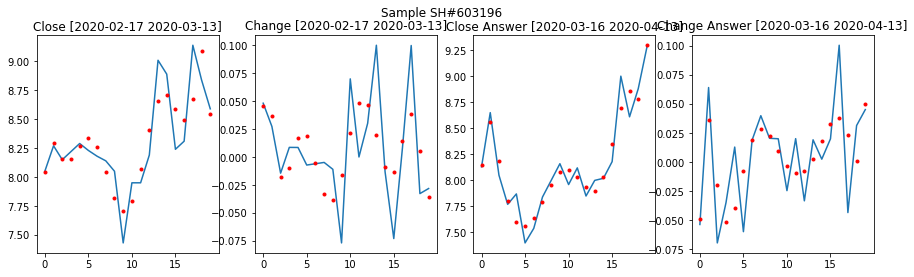

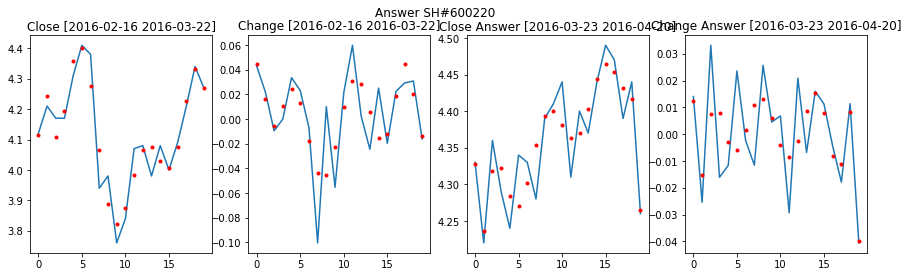

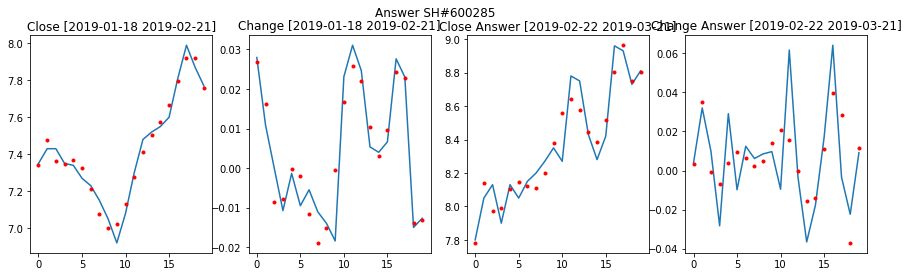

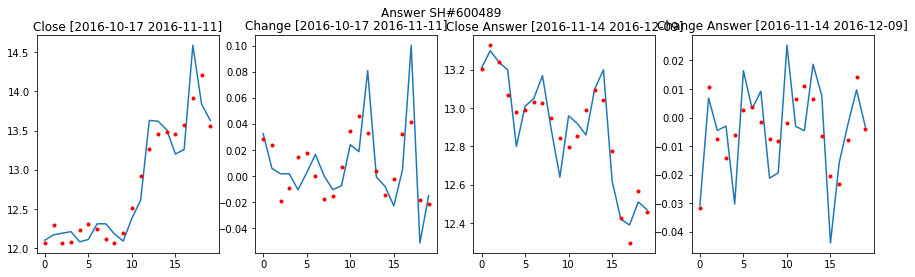

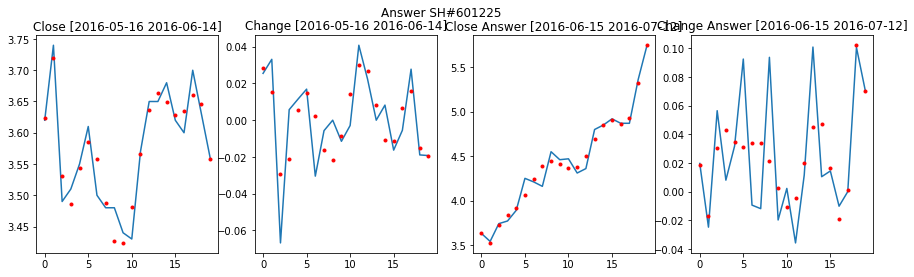

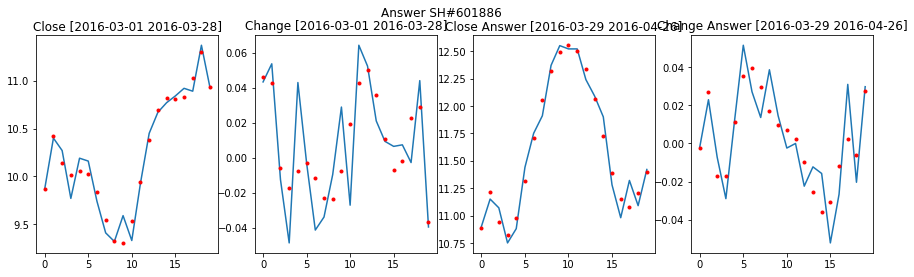

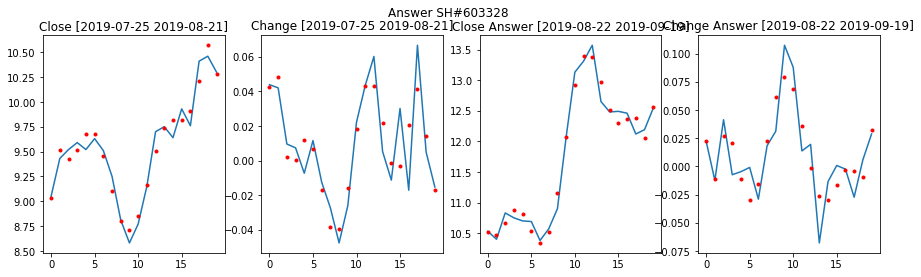

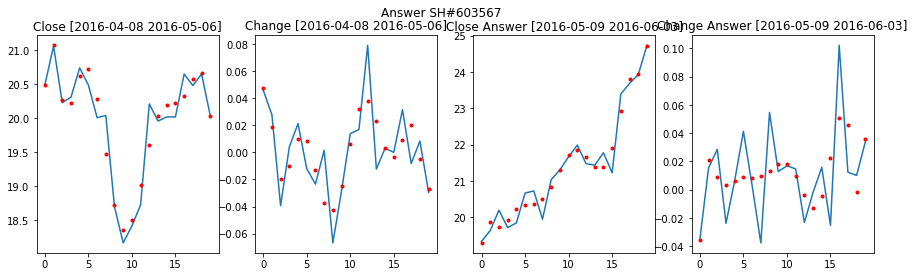

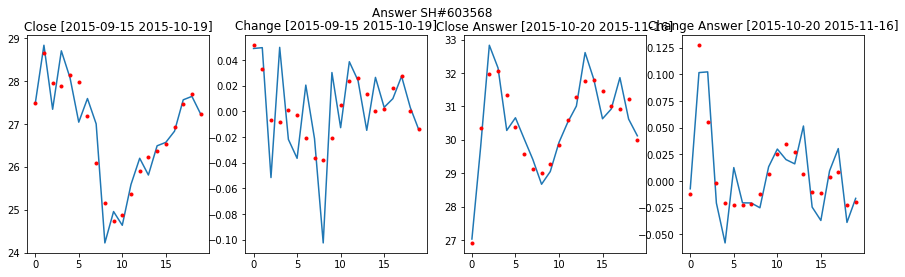

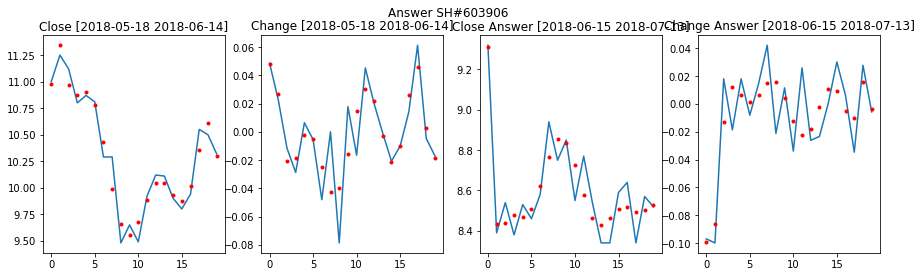

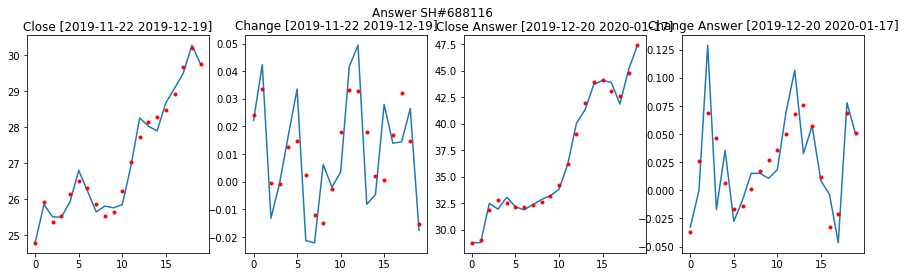

In [59]:
# sample_and_ans.index[-1].strftime('%Y-%m-%d')
def detail(sample_and_ans, ret):
    sample_part1 = sample_and_ans.head(period)
    sample_part2 = sample_and_ans.tail(period)
    sample_change = (sample_part2['Close'].iloc[-1] - sample_part2['Close'].iloc[0]) / sample_part2['Close'].iloc[0]
    print('sample_change       {}'.format(sample_change))

    dist_list = []
    for dist in ret.keys():
        dist_list.append(dist)
    np_dist_list = np.array(dist_list)
    dist_list_mean = np_dist_list.mean()
    print('dist mean      {}'.format(dist_list_mean))

    print('ans_cnt       {}'.format(len(ret[dist].keys())))

    ans_change_list = []
    for dist in ret.keys():
        ans_df_part1 = ret[dist].head(period)
        ans_df_part2 = ret[dist].tail(period)
        ans_change = (ans_df_part2['Close'].iloc[-1] - ans_df_part2['Close'].iloc[0]) / ans_df_part2['Close'].iloc[0]
        ans_change_list.append(ans_change)
    np_ans_change_list = np.array(ans_change_list)
    ans_mean = np_ans_change_list.mean()
    ans_std = np_ans_change_list.std()
    print('ans_mean      {}'.format(ans_mean))
    print('ans_std       {}'.format(ans_std))

    print(np_ans_change_list)
    print(np_dist_list)


    plot_sample_and_ans(sample_and_ans, 'Sample')
    for dist in ret.keys():
        plot_sample_and_ans(ret[dist], 'Answer')

detail(sample_and_ans, ret)

In [55]:
ret_cosine = loop_test(Global_DB['sha']['SH#600783'], method='cosine')

2020-05-19 10:56:08,580 [Similarity] SH#600783 in period [2020-02-17 00:00:00 2020-03-13 00:00:00]
[Similarity] Processing SH#600783 in sha |################################| 1611/1611Similarity] Processing SH#600783 in sha |###############                 | 781/1611[Similarity] Processing SH#600783 in sha |######################          | 1146/1611[Similarity] Processing SH#600783 in sha |##############################  | 1518/1611[Similarity] Processing SH#600783 in sha |##############################  | 1519/1611
2020-05-19 11:26:22,611 [Similarity] Processing SH#600783 in sha end, time elapse 1814.02778506279 seconds
2020-05-19 11:26:22,611 [Similarity] SH#600783 result length is 10, 1320921 samples are calculated


sample_change       0.0007336757153338068
dist mean      0.05230630938705919
ans_cnt       10
ans_mean      -0.027101851294494134
ans_std       0.09923232835002027
[-0.12648221 -0.03760163 -0.21721587 -0.05669291 -0.00687548  0.09924488
  0.15186615 -0.04868154  0.01939058 -0.04797048]
[0.06063159 0.06196704 0.04450546 0.05368461 0.05251923 0.05938685
 0.0492132  0.04099951 0.0382946  0.06186101]


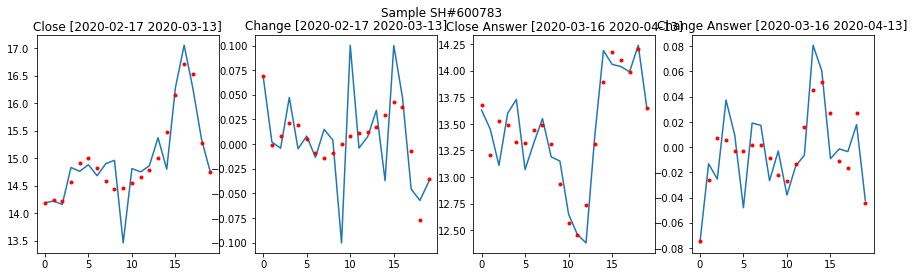

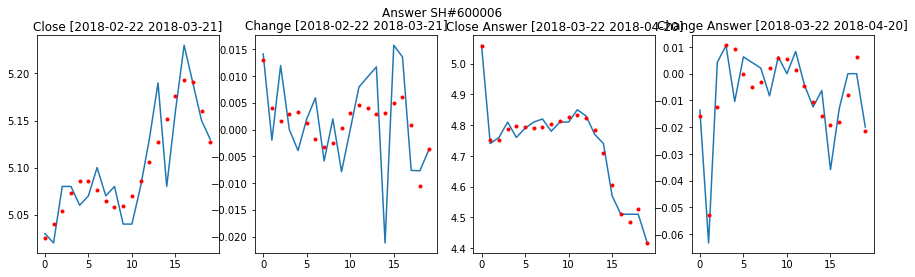

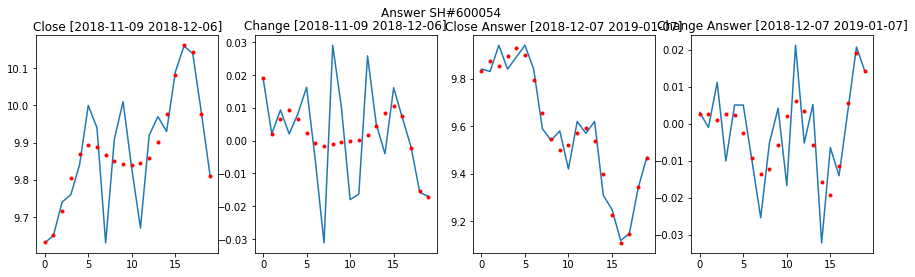

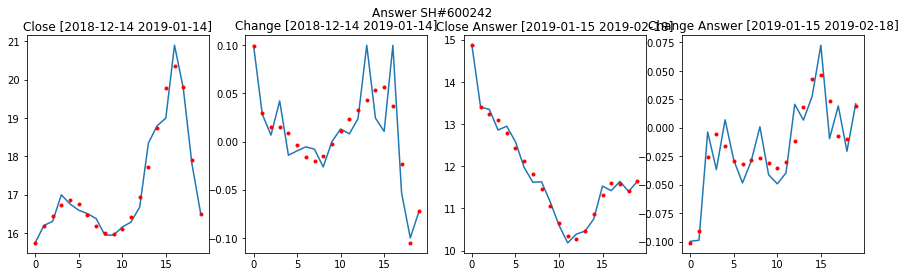

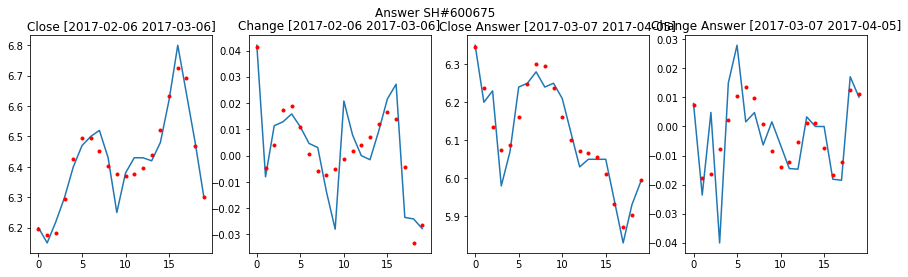

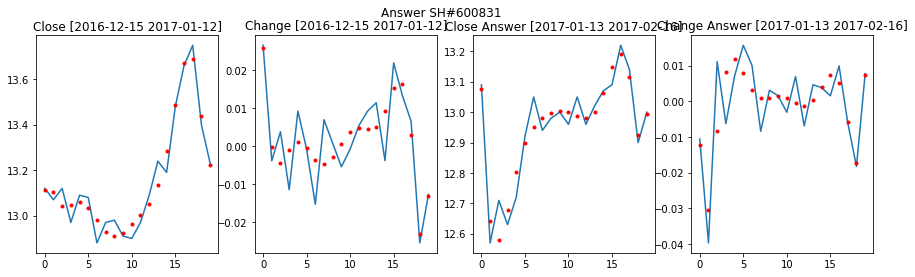

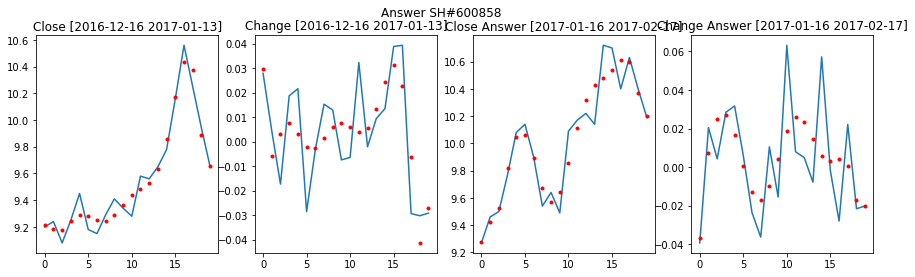

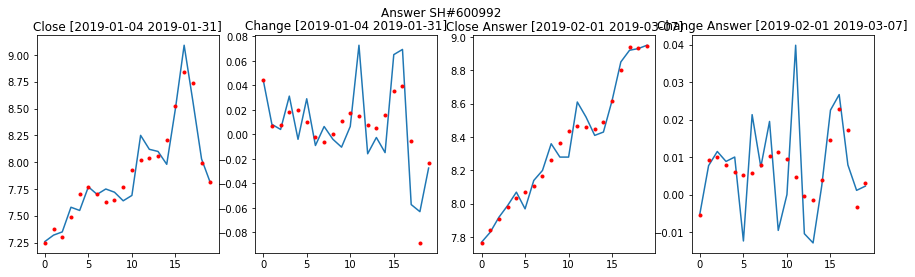

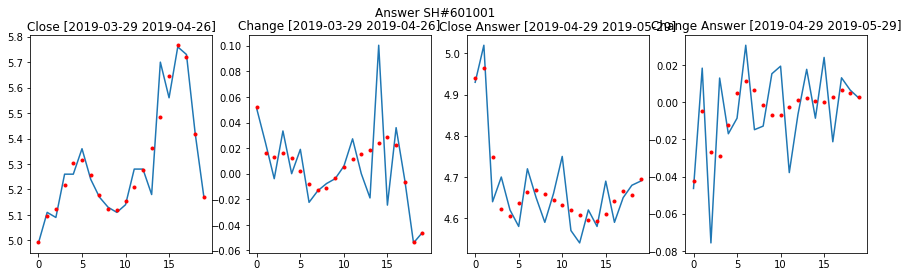

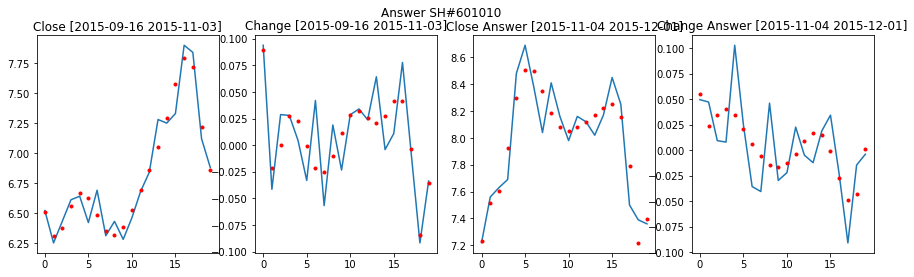

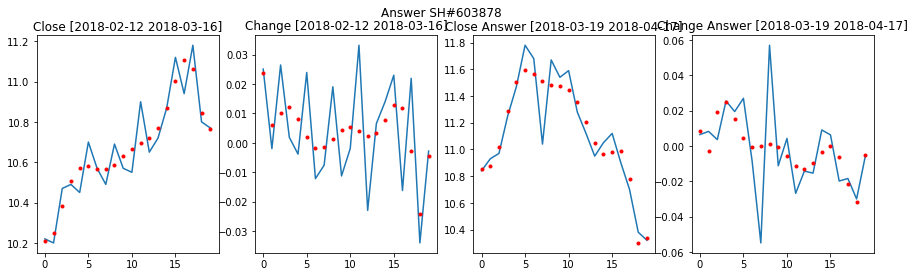

In [60]:
detail(Global_DB['sha']['SH#600783'].tail(3 * period).head(2 * period), ret_cosine)

In [64]:
ret_cosine_none_reg = loop_test(Global_DB['sha']['SH#600783'], method='cosine')

2020-05-19 12:01:51,939 [Similarity] SH#600783 in period [2020-02-17 00:00:00 2020-03-13 00:00:00]
[Similarity] Processing SH#600783 in sha |################################| 1611/1611[Similarity] Processing SH#600783 in sha |##############################  | 1527/1611[Similarity] Processing SH#600783 in sha |##############################  | 1541/1611[Similarity] Processing SH#600783 in sha |##############################  | 1548/1611[Similarity] Processing SH#600783 in sha |############################### | 1562/1611[Similarity] Processing SH#600783 in sha |############################### | 1567/1611[Similarity] Processing SH#600783 in sha |############################### | 1574/1611[Similarity] Processing SH#600783 in sha |############################### | 1578/1611[Similarity] Processing SH#600783 in sha |############################### | 1582/1611[Similarity] Processing SH#600783 in sha |############################### | 1599/1611[Similarity] Processing SH#600783 in sha |#########

sample_change       0.0007336757153338068
dist mean      0.16613014268018916
ans_cnt       10
ans_mean      0.011433156116816034
ans_std       0.14789327666386437
[ 0.04215457 -0.05720824 -0.17484663  0.15480132 -0.08353222  0.19266055
 -0.0375     -0.20274914  0.00896861  0.27158273]
[0.16851341 0.19078581 0.14546844 0.18039707 0.18878797 0.18480485
 0.15464074 0.14374431 0.11486711 0.18929172]


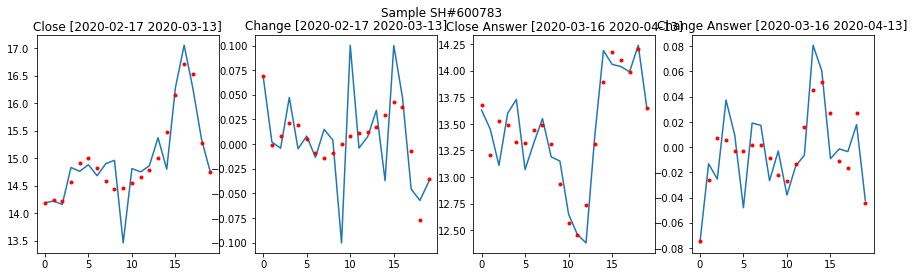

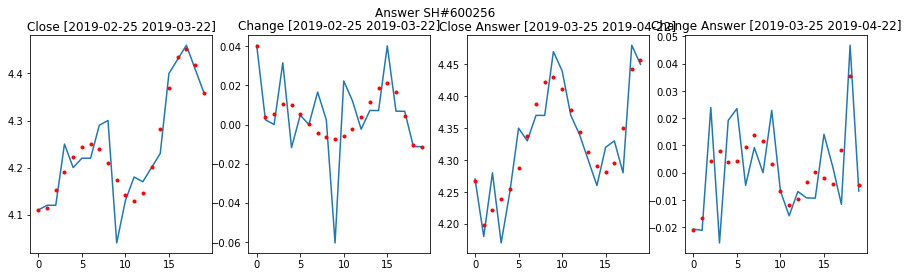

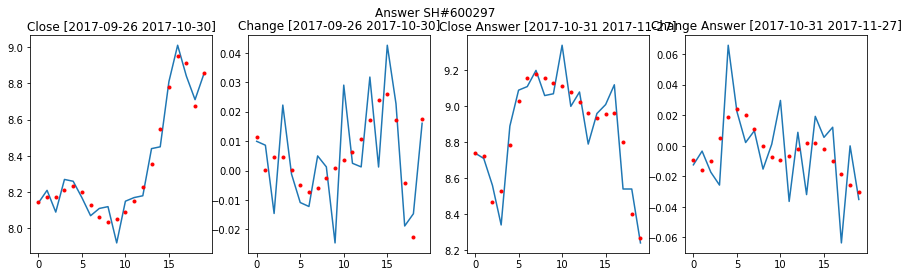

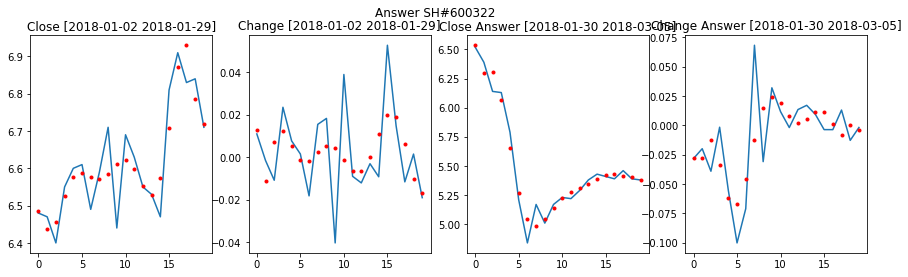

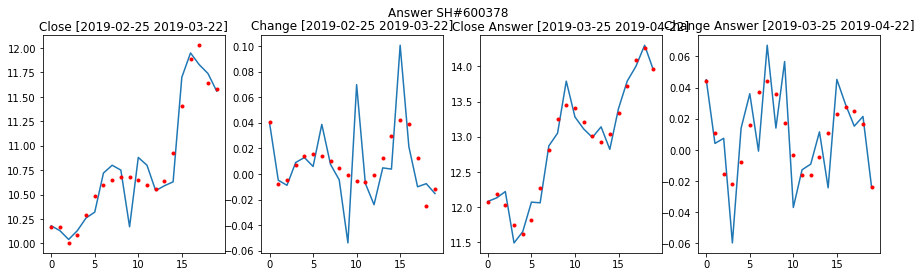

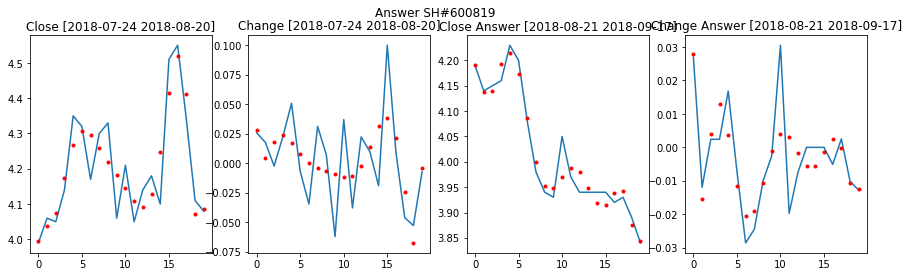

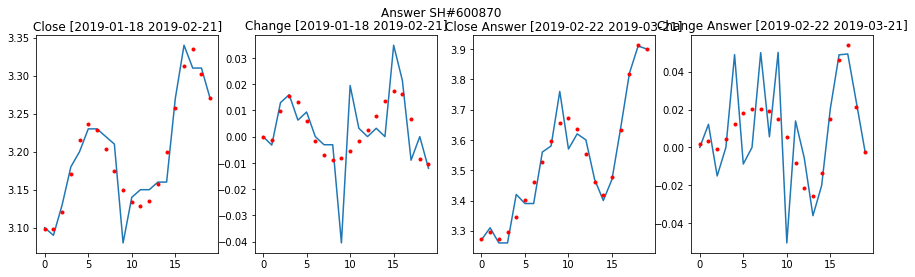

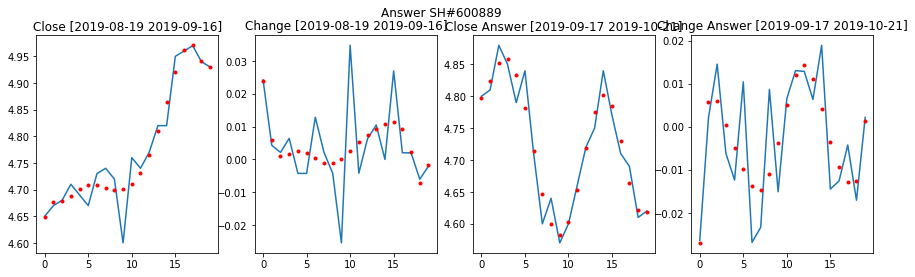

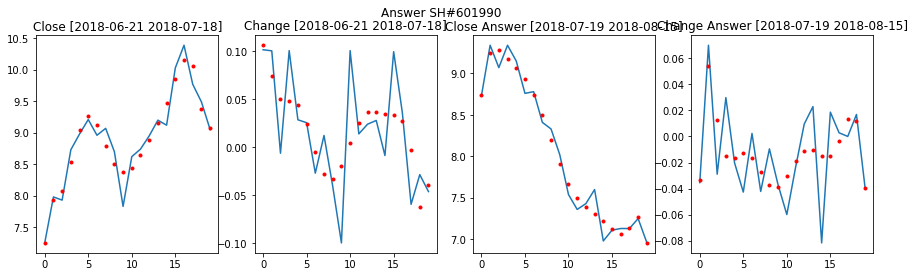

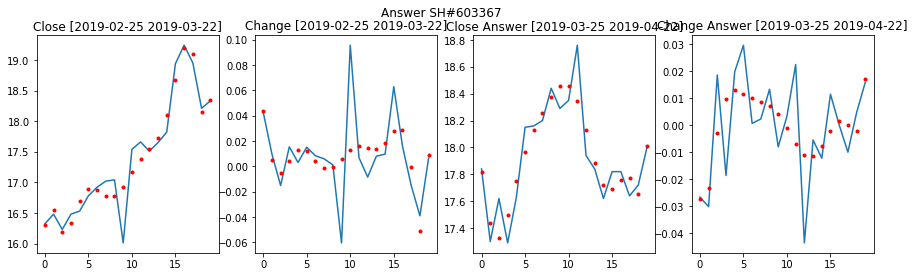

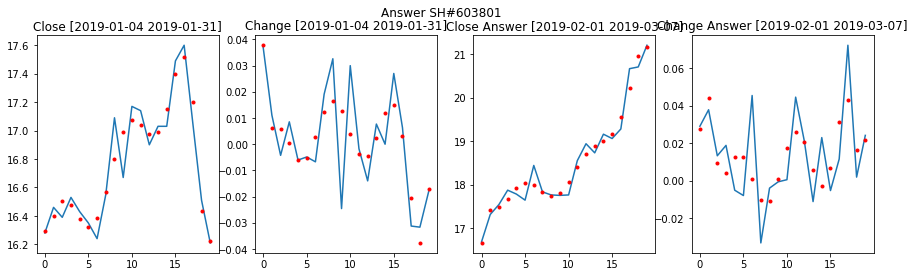

In [66]:
detail(Global_DB['sha']['SH#600783'].tail(3 * period).head(2 * period), ret_cosine_none_reg)

In [67]:
ret_none_reg = loop_test(Global_DB['sha']['SH#600783'], method='shebyshev')

2020-05-19 12:25:47,356 [Similarity] SH#600783 in period [2020-02-17 00:00:00 2020-03-13 00:00:00]
[Similarity] Processing SH#600783 in sha |################################| 1611/1611[Similarity] Processing SH#600783 in sha |########################        | 1217/1611[Similarity] Processing SH#600783 in sha |##############################  | 1544/1611[Similarity] Processing SH#600783 in sha |############################### | 1593/1611
2020-05-19 12:45:00,714 [Similarity] Processing SH#600783 in sha end, time elapse 1153.3556141853333 seconds
2020-05-19 12:45:00,715 [Similarity] SH#600783 result length is 1, 1320921 samples are calculated


In [69]:
# detail(Global_DB['sha']['SH#600783'].tail(3 * period).head(2 * period), ret_none_reg)


ret_none_reg.keys()

dict_keys([None])